# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [ ]:
!pip3 -qq install torch==0.4.1
!pip3 -qq install bokeh==0.13.0
!pip3 -qq install gensim==3.6.0
!pip3 -qq install nltk
!pip3 -qq install scikit-learn==0.20.2

In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0")

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [2]:
import nltk

nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /home/mikhail/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/mikhail/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [3]:
import nltk
from sklearn.model_selection import train_test_split

data = nltk.corpus.brown.tagged_sents(tagset='universal')

Пример размеченного предложения:

In [4]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [5]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


In [9]:
train_data[0]

[('``', '.'),
 ('What', 'DET'),
 ('did', 'VERB'),
 ('you', 'PRON'),
 ('think', 'VERB'),
 ('about', 'ADP'),
 ("Bang-Jensen's", 'NOUN'),
 ('contention', 'NOUN'),
 ('of', 'ADP'),
 ('errors', 'NOUN'),
 ('and', 'CONJ'),
 ('omissions', 'NOUN'),
 ('in', 'ADP'),
 ('the', 'DET'),
 ('Hungarian', 'ADJ'),
 ('report', 'NOUN'),
 ("''", '.'),
 ('?', '.'),
 ('?', '.')]

Построим маппинги из слов в индекс и из тега в индекс:


In [10]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'ADV', 'DET', 'ADJ', 'NUM', 'X', 'PRON', 'CONJ', '.', 'PRT', 'NOUN', 'VERB', 'ADP'}


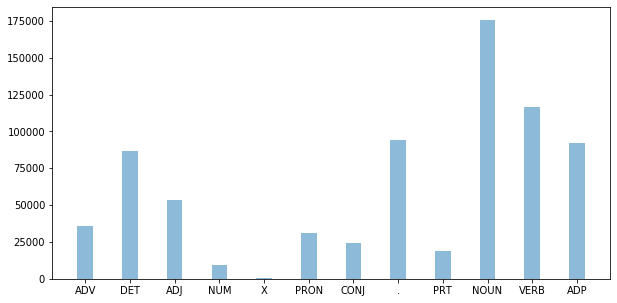

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [13]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [14]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [15]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [16]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [19]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [20]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [99]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.lstm_hidden_dim = lstm_hidden_dim
        # embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        
        # lstm layer
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim)
        
        # linear layer outputs tag
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        # make embeddings from input
        embeds = self.word_embeddings(inputs)
        # pass through lstm layer
        lstm_out, _ = self.lstm(embeds.view(inputs.numel(), 1, -1))
        # pass through linear layer
        tag_space = self.hidden2tag(lstm_out.view(inputs.numel(), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        return tag_scores

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [126]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)
logits = model(X_batch)

def calc_accuracy(target, preds):
    """
    Calculate accuracy for model
    """
    _, inds = torch.max(preds, dim=1)
    correct_samples = torch.sum(target.view(-1) == inds).item()
    
    return correct_samples, inds.numel()

print(calc_accuracy(y_batch, logits))

(6, 128)


In [127]:
criterion = nn.CrossEntropyLoss()
loss_value = criterion(logits, y_batch.view(-1)).item()
loss_value

2.589792251586914

**Задание** Вставьте эти вычисление в функцию:

In [210]:
import math
from tqdm import tqdm

def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits, y_batch.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                #cur_correct_count, cur_sum_count = calc_accuracy(y_batch, logits)
                cur_correct_count, cur_sum_count = calc_accuracy_pad(y_batch, logits)
                
                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, 
        epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, 
                                         optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, 
                                         None, name_prefix + '  Val:')

In [129]:
%%time
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), 
    epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), 
    val_batch_size=512)

[1 / 50] Train: Loss = 0.32777, Accuracy = 90.32%: 100%|██████████| 572/572 [00:54<00:00, 10.58it/s]
[1 / 50]   Val: Loss = 0.13688, Accuracy = 96.93%: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
[2 / 50] Train: Loss = 0.10981, Accuracy = 96.51%: 100%|██████████| 572/572 [00:54<00:00, 10.47it/s]
[2 / 50]   Val: Loss = 0.11584, Accuracy = 97.76%: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
[3 / 50] Train: Loss = 0.07967, Accuracy = 97.41%: 100%|██████████| 572/572 [00:54<00:00, 10.56it/s]
[3 / 50]   Val: Loss = 0.10839, Accuracy = 98.11%: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
[4 / 50] Train: Loss = 0.06490, Accuracy = 97.81%: 100%|██████████| 572/572 [00:54<00:00, 10.59it/s]
[4 / 50]   Val: Loss = 0.09859, Accuracy = 98.36%: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
[5 / 50] Train: Loss = 0.05622, Accuracy = 98.05%: 100%|██████████| 572/572 [00:54<00:00, 10.57it/s]
[5 / 50]   Val: Loss = 0.10646, Accuracy = 98.34%: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


[41 / 50]   Val: Loss = 0.12194, Accuracy = 98.60%: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
[42 / 50] Train: Loss = 0.03041, Accuracy = 98.70%: 100%|██████████| 572/572 [00:52<00:00, 10.97it/s]
[42 / 50]   Val: Loss = 0.12959, Accuracy = 98.60%: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
[43 / 50] Train: Loss = 0.03062, Accuracy = 98.70%: 100%|██████████| 572/572 [00:51<00:00, 11.00it/s]
[43 / 50]   Val: Loss = 0.14247, Accuracy = 98.45%: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
[44 / 50] Train: Loss = 0.03074, Accuracy = 98.70%: 100%|██████████| 572/572 [00:52<00:00, 10.99it/s]
[44 / 50]   Val: Loss = 0.14769, Accuracy = 98.48%: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
[45 / 50] Train: Loss = 0.03020, Accuracy = 98.71%: 100%|██████████| 572/572 [00:54<00:00, 10.45it/s]
[45 / 50]   Val: Loss = 0.13443, Accuracy = 98.61%: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
[46 / 50] Train: Loss = 0.03017, Accuracy = 98.71%: 100%|██████████| 572/572 [00:55<00:00, 1

CPU times: user 45min 11s, sys: 6min 46s, total: 51min 57s
Wall time: 51min 13s


### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

In [186]:
model_2 = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)
logits = model_2(X_batch)

In [187]:
def calc_accuracy_pad(target, preds):
    """
    Calculate accuracy for model
    """
    zero_mask = (target == 0).view(-1)
    _, inds = torch.max(preds[1-zero_mask], dim=1)
    correct_samples = torch.sum(target.view(-1)[1-zero_mask] == inds).item()
    
    return correct_samples, inds.numel()

print(calc_accuracy(y_batch, logits))
print(calc_accuracy_pad(y_batch, logits))

(30, 128)
(10, 92)


In [189]:
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss(ignore_index=0)
loss_value1 = criterion1(logits, y_batch.view(-1)).item()
loss_value2 = criterion2(logits, y_batch.view(-1)).item()
print(loss_value1, loss_value2)

2.5266876220703125 2.55135440826416


**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [197]:
def evaluate_model(model, data, batch_size):
    
    correct_count = 0
    sum_count = 0
    
    model.eval() # evaluation mode
    
    for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                
        X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
        logits = model(X_batch)

        cur_correct_count, cur_sum_count = calc_accuracy_pad(y_batch, logits)
        #cur_correct_count, cur_sum_count = calc_accuracy(y_batch, logits)
        
        correct_count += cur_correct_count
        sum_count += cur_sum_count
    
    return float(correct_count/sum_count)

In [198]:
%%time
# calc_accuracy
res = evaluate_model(model, (X_test, y_test), batch_size=32)
print(res)

0.9726758612730105
CPU times: user 7.66 s, sys: 1.28 s, total: 8.94 s
Wall time: 8.93 s


In [195]:
%%time
# calc_accuracy_pad
res = evaluate_model(model, (X_test, y_test), batch_size=32)
print(res)

0.9251486389253242
CPU times: user 7.98 s, sys: 1.14 s, total: 9.12 s
Wall time: 9.11 s


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [207]:
class BidirLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.lstm_hidden_dim = lstm_hidden_dim
        # embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        
        # lstm layer
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, bidirectional=True)
        
        # linear layer outputs tag
        self.hidden2tag = nn.Linear(lstm_hidden_dim*2, tagset_size)

    def forward(self, inputs):
        # make embeddings from input
        embeds = self.word_embeddings(inputs)
        # pass through lstm layer
        lstm_out, _ = self.lstm(embeds.view(inputs.numel(), 1, -1))
        # pass through linear layer
        tag_space = self.hidden2tag(lstm_out.view(inputs.numel(), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        return tag_scores

In [208]:
%%time
model_3 = BidirLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model_3.parameters())

fit(model_3, criterion, optimizer, train_data=(X_train, y_train), 
    epochs_count=20,
    batch_size=256, val_data=(X_val, y_val), 
    val_batch_size=512)

[1 / 20] Train: Loss = 0.50748, Accuracy = 43.77%: 100%|██████████| 143/143 [02:04<00:00,  1.15it/s]
[1 / 20]   Val: Loss = 0.23760, Accuracy = 66.08%: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it]
[2 / 20] Train: Loss = 0.18640, Accuracy = 76.54%: 100%|██████████| 143/143 [02:01<00:00,  1.18it/s]
[2 / 20]   Val: Loss = 0.14490, Accuracy = 81.55%: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it]
[3 / 20] Train: Loss = 0.10744, Accuracy = 86.34%: 100%|██████████| 143/143 [02:01<00:00,  1.18it/s]
[3 / 20]   Val: Loss = 0.11628, Accuracy = 86.79%: 100%|██████████| 13/13 [00:14<00:00,  1.08s/it]
[4 / 20] Train: Loss = 0.07845, Accuracy = 90.01%: 100%|██████████| 143/143 [01:59<00:00,  1.19it/s]
[4 / 20]   Val: Loss = 0.10893, Accuracy = 88.92%: 100%|██████████| 13/13 [00:13<00:00,  1.05s/it]
[5 / 20] Train: Loss = 0.06412, Accuracy = 91.62%: 100%|██████████| 143/143 [01:59<00:00,  1.19it/s]
[5 / 20]   Val: Loss = 0.10810, Accuracy = 89.94%: 100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


CPU times: user 38min 48s, sys: 6min 5s, total: 44min 54s
Wall time: 44min 33s


In [211]:
%%time
# calc_accuracy_pad
res = evaluate_model(model_3, (X_test, y_test), batch_size=128)
print(res)

0.9791789216971482
CPU times: user 19.3 s, sys: 2.97 s, total: 22.3 s
Wall time: 22.3 s


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [ ]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

Построим подматрицу для слов из нашей тренировочной выборки:

In [ ]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [ ]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        <create me>

    def forward(self, inputs):
        <use me>

In [ ]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [ ]:
<calc test accuracy>